In [62]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

import numpy as np 
import matplotlib.pyplot as plt
    
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

from astropy.table import Table, Column, vstack
from astroML.stats import binned_statistic_2d


%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

# Personal repo
from asap.um_prepare_catalog import prep_um_catalog
from asap.um_vagc_mock import *
    
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from colossus.halo.mass_so import dynamicalTime

from colossus.cosmology import cosmology

### Read in the UniverseMachine catalog

In [4]:
smdpl_dir = "/Users/song/data/massive/umachine/1806/smdpl_nomergers/"

um_cat = np.load(os.path.join(smdpl_dir, 'um_smdpl_insitu_exsitu_0.7124_basic_logmv_11.5.npy'))

mask_cen = um_cat['upid'] == -1

um_cen = um_cat[mask_cen]

print(len(um_cat), len(um_cen))

1255175 1076948


In [5]:
um_cen.dtype

dtype([('halo_id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('mvir', '<f8'), ('mpeak', '<f8'), ('vmp', '<f8'), ('r', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('ssfr', '<f8'), ('pid', '<f8'), ('mvir_hlist', '<f8'), ('rvir_hlist', '<f8'), ('rs_hlist', '<f8'), ('scale_half_mass', '<f8'), ('scale_last_mm', '<f8'), ('m200b_hlist', '<f8'), ('m200c_hlist', '<f8'), ('gamma_inst', '<f8'), ('gamma_100myr', '<f8'), ('gamma_1tdyn', '<f8'), ('gamma_2tdyn', '<f8'), ('gamma_mpeak', '<f8'), ('vmax_mpeak', '<f8'), ('halo_hostid', '<i8'), ('mhalo_host', '<f8'), ('mask_central', '?'), ('mtot_galaxy', '<f8'), ('mstar_mhalo', '<f8'), ('logms_gal', '<f8'), ('logms_icl', '<f8'), ('logms_tot', '<f8'), ('logms_halo', '<f8'), ('logmh_vir', '<f8'), ('logmh_peak', '<f8'), ('logmh_host', '<f8')])

### Measure the unitless accretion rate

In [76]:
# FIND DELTA M
cosmo = cosmology.setCosmology('planck13') # for the MDPL2 case 

# Scaling factor
sf_now = 0.73330

# Get the gamma values from the catalog
gamma_ct = um_cen["gamma_2tdyn"]

# Get dynamical time 
z_now = (1. - sf_now) / sf_now
dyntime_ct = dynamicalTime(z_now, "vir", definition='crossing') * 1e9 # in years

# Get deltaM 
delta_mvir = gamma_ct * dyntime_ct

# Halo mass now 
mvir_now = um_cen["mvir_hlist"]

# Halo mass at two dynamic times ago
mvir_then = mvir_now - delta_mvir

# FIND SF 1 TDYN AGO USING SPARTA'S METHOD 

## get dynamical time                                                           
dyntime_sp = dynamicalTime(z_now, "vir", definition='crossing') * 1e9 # in years    

# ----- FIND SF 1 TDYN AGO USING SPARTA'S METHOD -------                        

# ## time now                                                                   
time_snapshot = cosmo.age(z_now, inverse = False) * 1e9

# ## time back 1tdyn                                                            
time_back1dyn = time_snapshot - dyntime_sp

## scale factor itdyn ago                                                       
z_back1dyn = cosmo.age(time_back1dyn / 1e9, inverse=True)                                              

sf_back1dyn = 1.0 / (1.0 + z_back1dyn)


# FIND THE NEW GAMMA
gamma_sp = np.log10(mvir_now / mvir_then) / np.log10(sf_now / sf_back1dyn)

mask_use = (np.isfinite(gamma_sp) & (gamma_sp >= -4.9) & 
            np.isfinite(um_cen['sfr']) * (um_cen['sfr'] > 0.0))

mask_massive = (np.isfinite(gamma_sp) & (gamma_sp >= -4.9) & 
                np.isfinite(um_cen['sfr']) * (um_cen['sfr'] > 0.0) &
                (np.log10(um_cen['mvir']) >= 13.5))

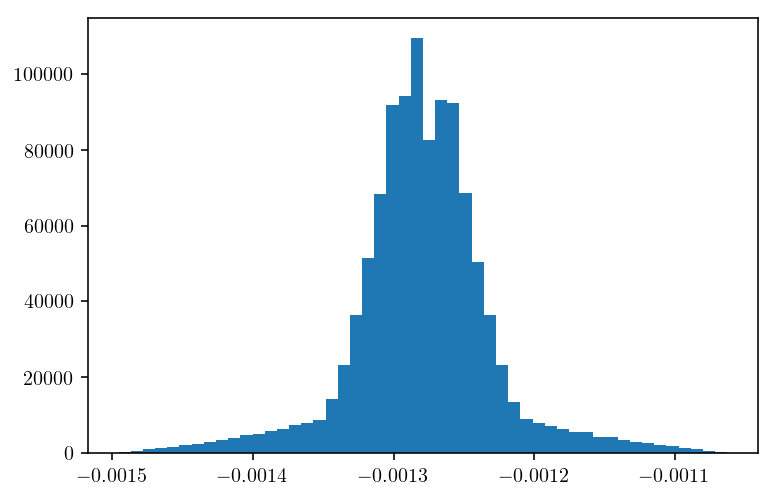

In [58]:
_ = plt.hist(np.log10(um_cen['mvir']) - np.log10(um_cen['mvir_hlist'] / 0.678), bins=50)

### Making figures

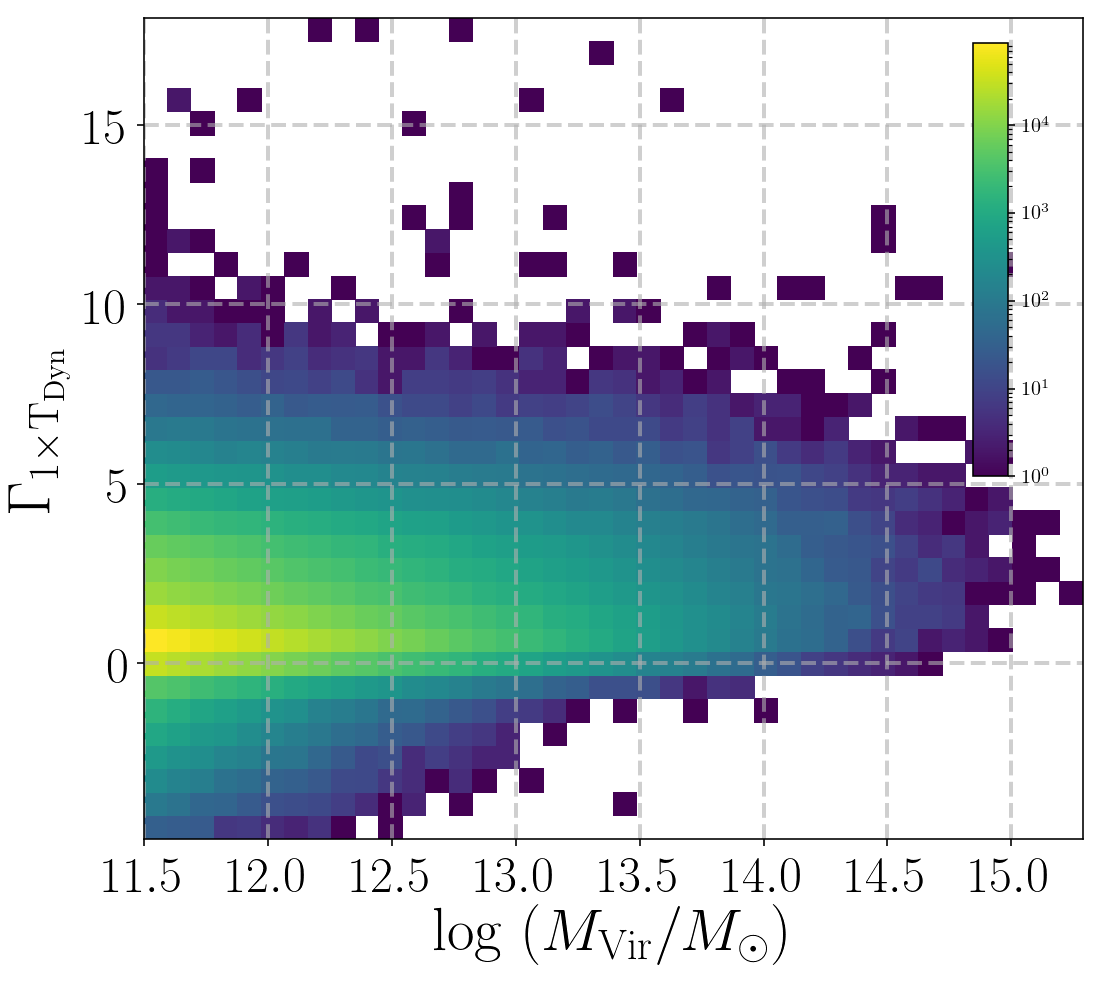

In [59]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

_, _, _, cax1 = ax1.hist2d(um_cen[mask_use]['logmh_vir'], gamma_sp[mask_use], 
    bins=[40, 35], norm=LogNorm())

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.54, 0.03, 0.43]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\Gamma_{1\times \mathrm{T}_{\mathrm{Dyn}}}$', fontsize=30)

Text(0, 0.5, '$\\log\\ (\\mathrm{SFR}/[M_{\\odot}\\ \\mathrm{yr}^{-1}])$')

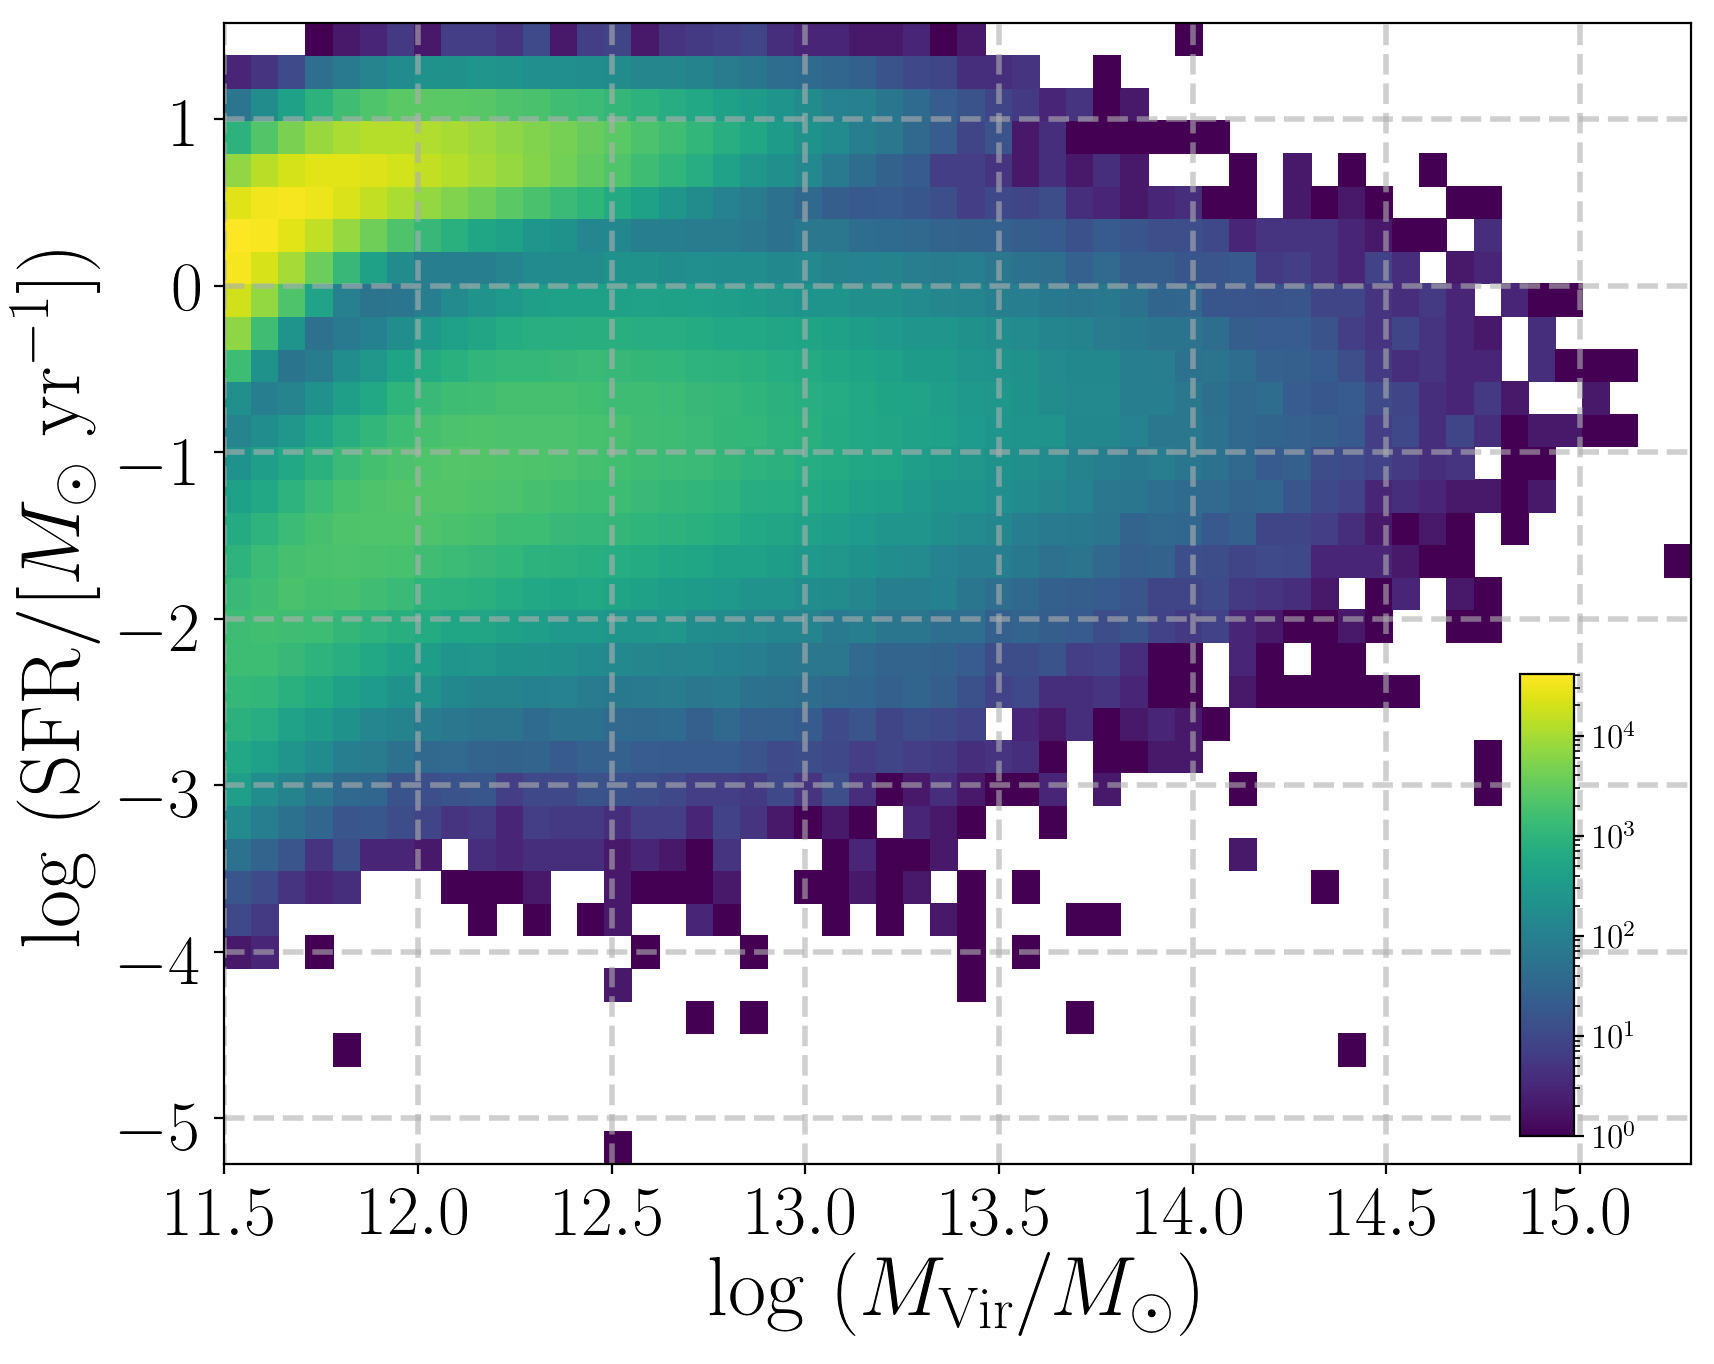

In [75]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

_, _, _, cax1 = ax1.hist2d(
    um_cen[mask_use]['logmh_vir'], 
    np.log10(um_cen[mask_use]['sfr']), 
    bins=[54, 35], norm=LogNorm())

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.20, 0.03, 0.33]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
ax1.set_ylabel(r'$\log\ (\mathrm{SFR}/[M_{\odot}\ \mathrm{yr}^{-1}])$', fontsize=30)

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


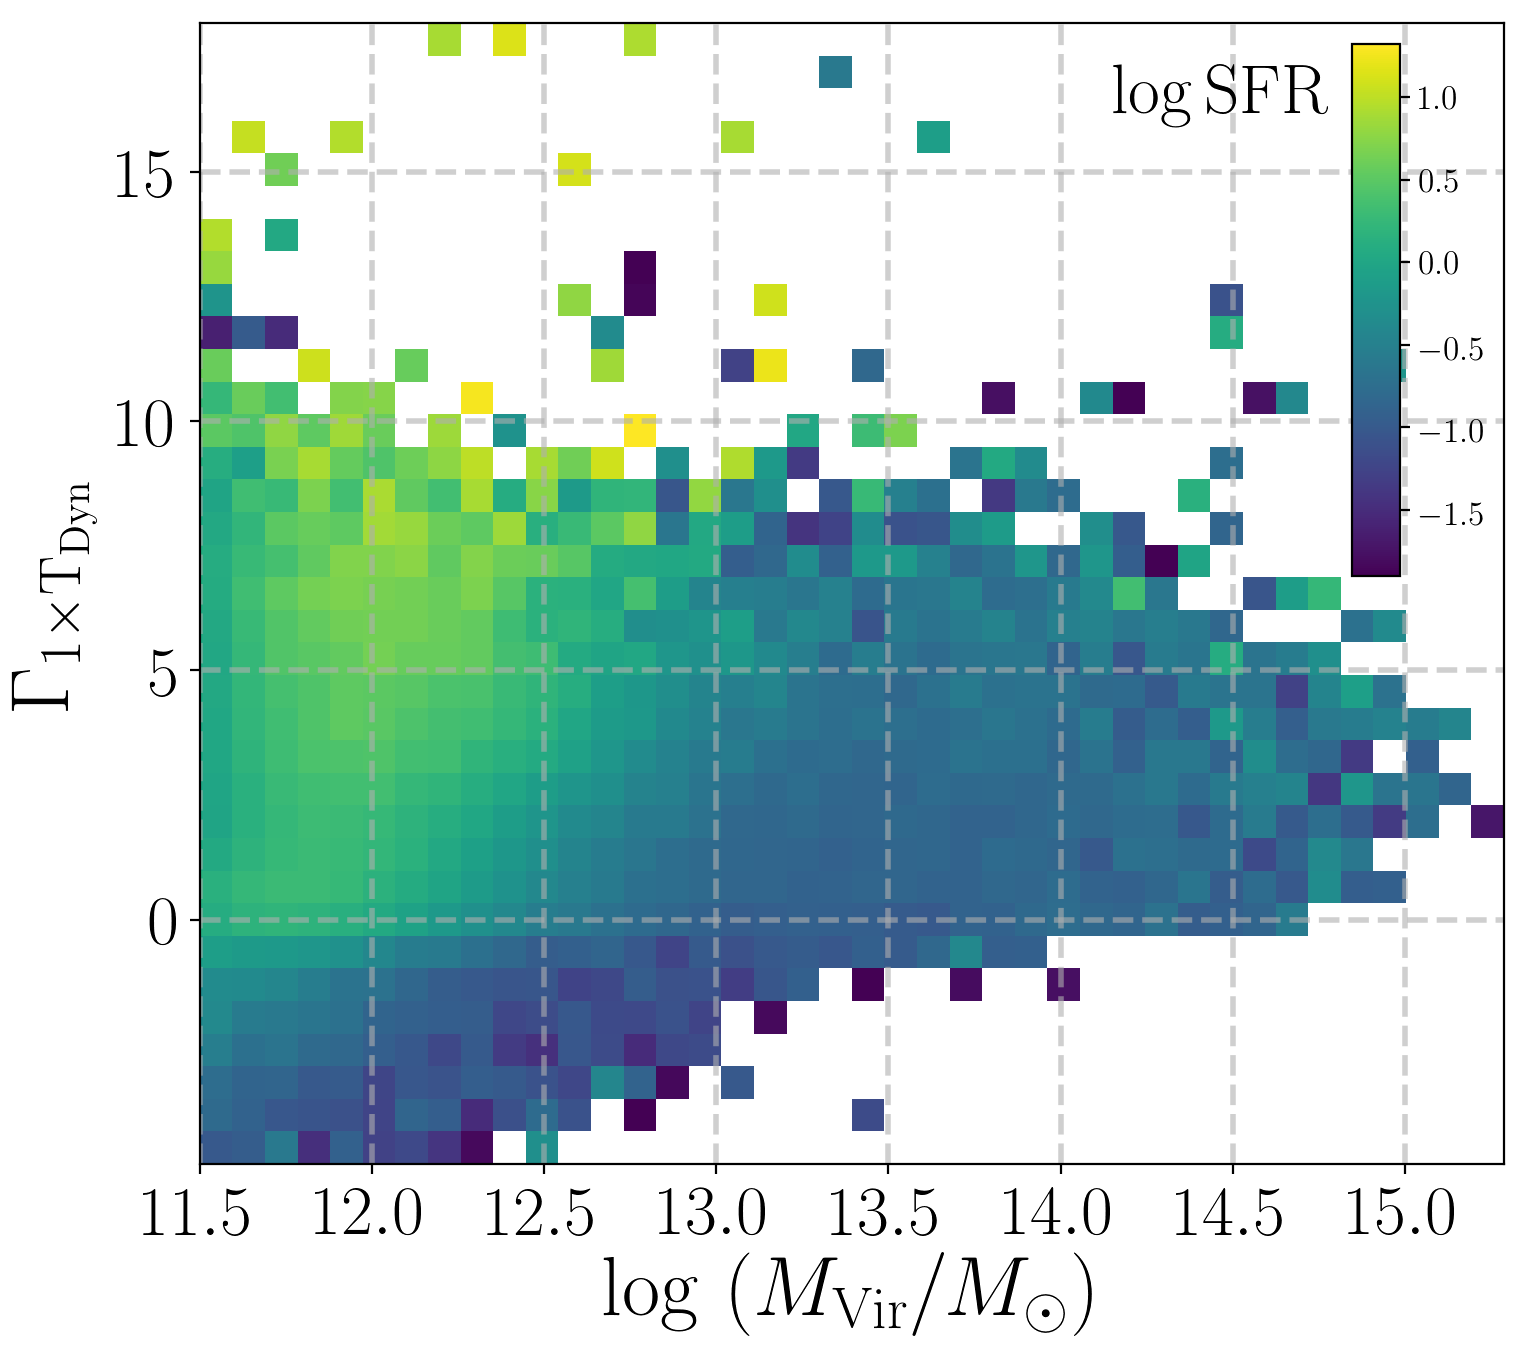

In [67]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

sfr_mean, xedges, yedges = binned_statistic_2d(
    um_cen[mask_use]['logmh_vir'], gamma_sp[mask_use],
    np.log10(um_cen[mask_use]['sfr']), 
    'mean', bins=[40, 35])

cax1 = ax1.imshow(sfr_mean.T, origin='lower', vmin=-1.9,
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                  aspect='auto', interpolation='nearest')

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.60, 0.03, 0.38]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.text(0.70, 0.92, r'$\log\mathrm{SFR}$', fontsize=25, transform=ax1.transAxes)
    
_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\Gamma_{1\times \mathrm{T}_{\mathrm{Dyn}}}$', fontsize=30)

Text(0, 0.5, '$\\log\\ (\\mathrm{sSFR}/[\\mathrm{yr}^{-1}])$')

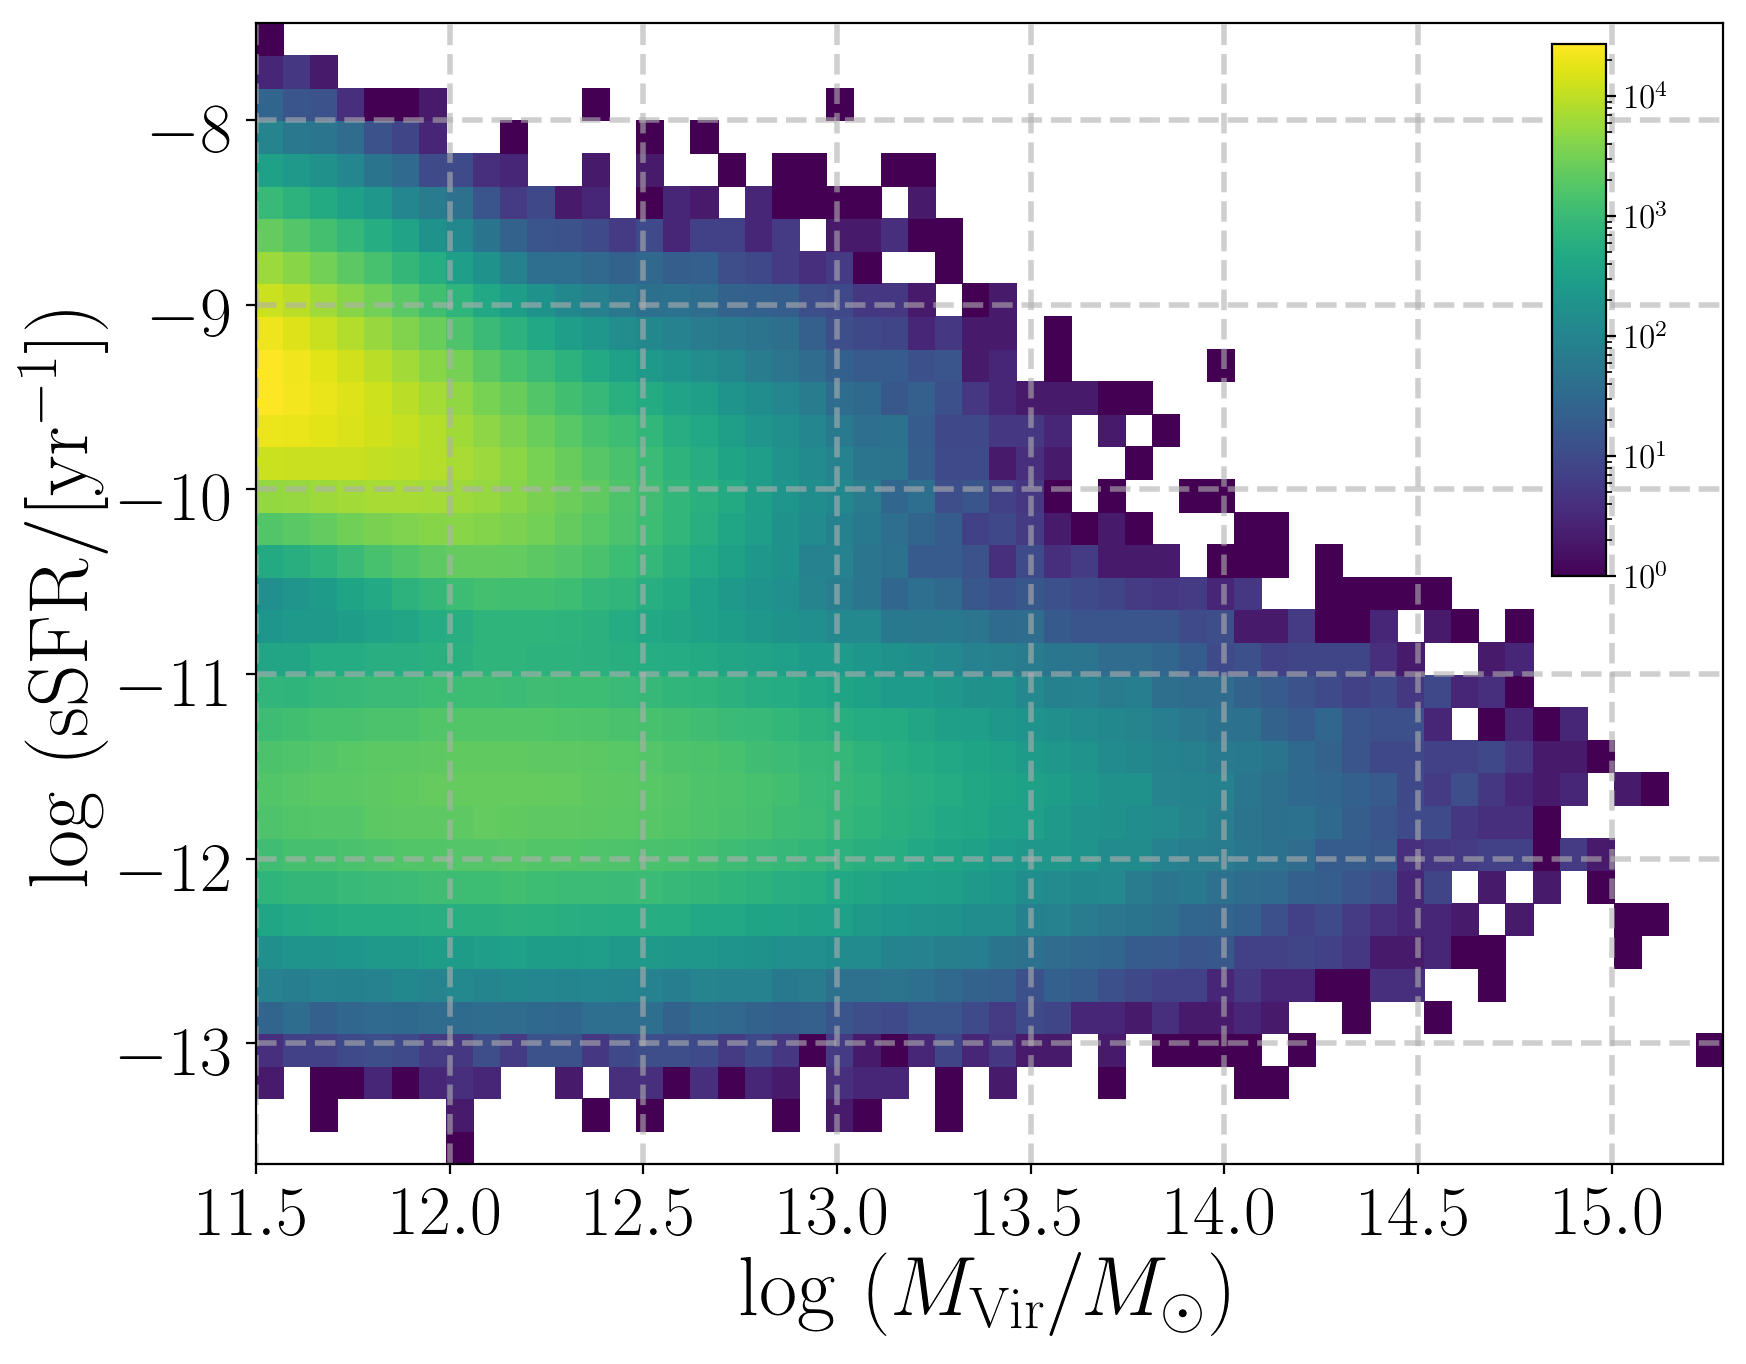

In [69]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

_, _, _, cax1 = ax1.hist2d(
    um_cen[mask_use]['logmh_vir'], 
    np.log10(um_cen[mask_use]['ssfr']), 
    bins=[54, 35], norm=LogNorm())

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.60, 0.03, 0.38]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
ax1.set_ylabel(r'$\log\ (\mathrm{sSFR}/[\mathrm{yr}^{-1}])$', fontsize=30)

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


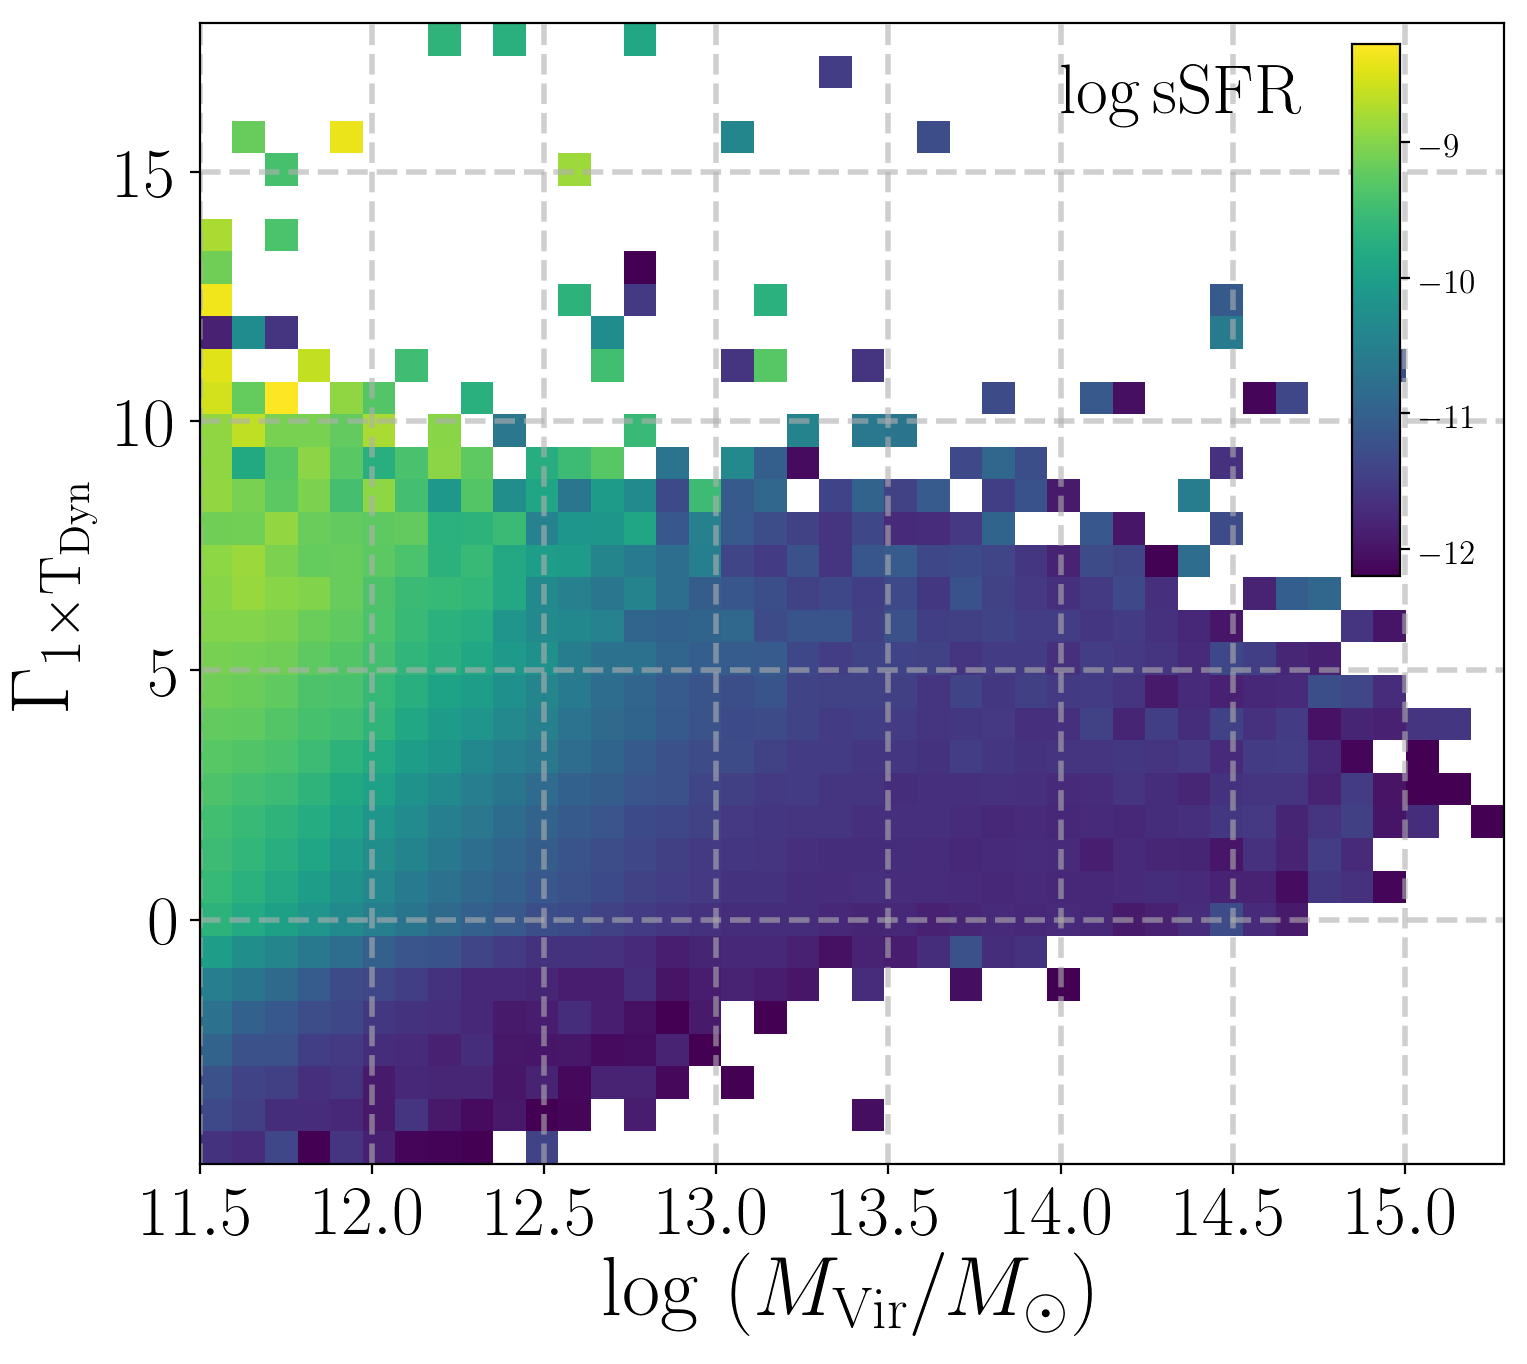

In [74]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

sfr_mean, xedges, yedges = binned_statistic_2d(
    um_cen[mask_use]['logmh_vir'], gamma_sp[mask_use],
    np.log10(um_cen[mask_use]['ssfr']), 
    'mean', bins=[40, 35])

cax1 = ax1.imshow(sfr_mean.T, origin='lower', vmin=-12.2,
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                  aspect='auto', interpolation='nearest')

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.60, 0.03, 0.38]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.text(0.66, 0.92, r'$\log\mathrm{sSFR}$', fontsize=25, transform=ax1.transAxes)
    
_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\Gamma_{1\times \mathrm{T}_{\mathrm{Dyn}}}$', fontsize=30)

### Just for the massive haloes

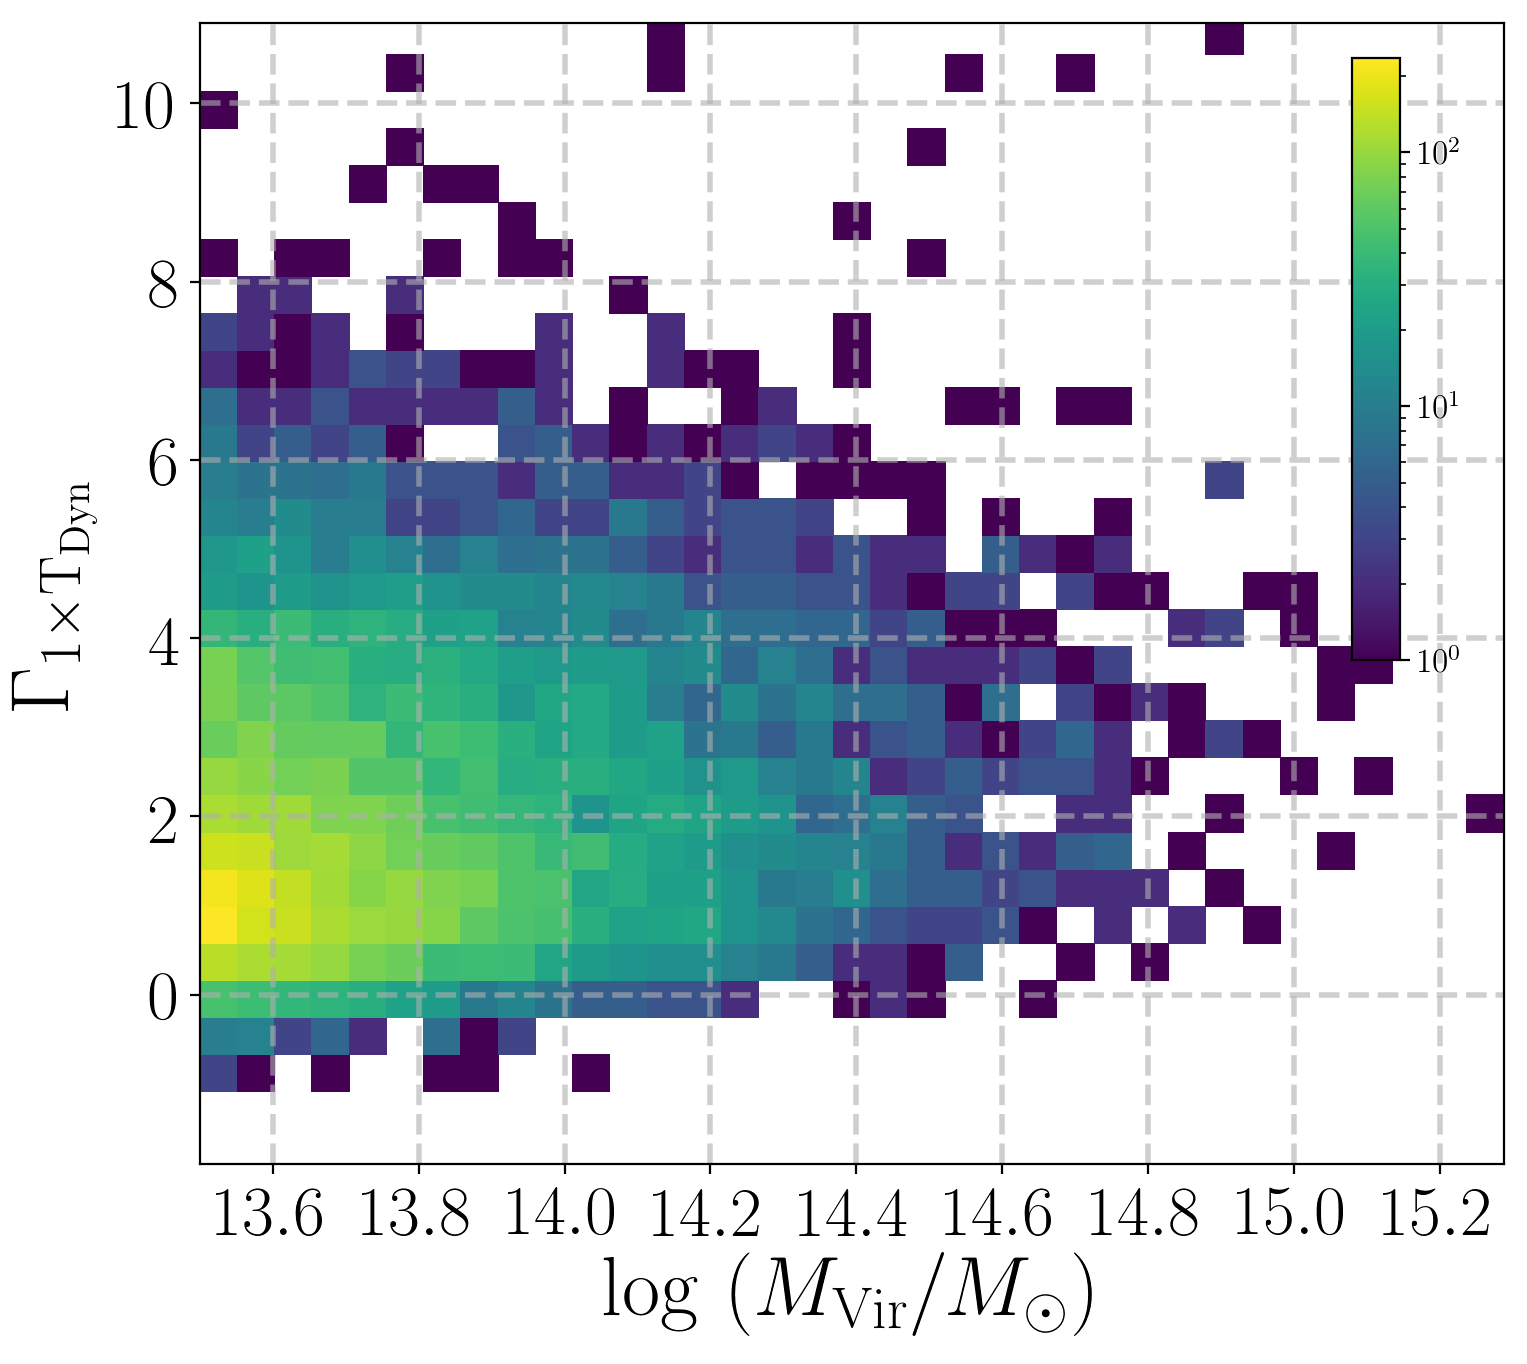

In [85]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

_, _, _, cax1 = ax1.hist2d(um_cen[mask_massive]['logmh_vir'], gamma_sp[mask_massive], 
    bins=[35, 40], norm=LogNorm())

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.54, 0.03, 0.43]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_ylim(-1.9, 10.9)
    
_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\Gamma_{1\times \mathrm{T}_{\mathrm{Dyn}}}$', fontsize=30)

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


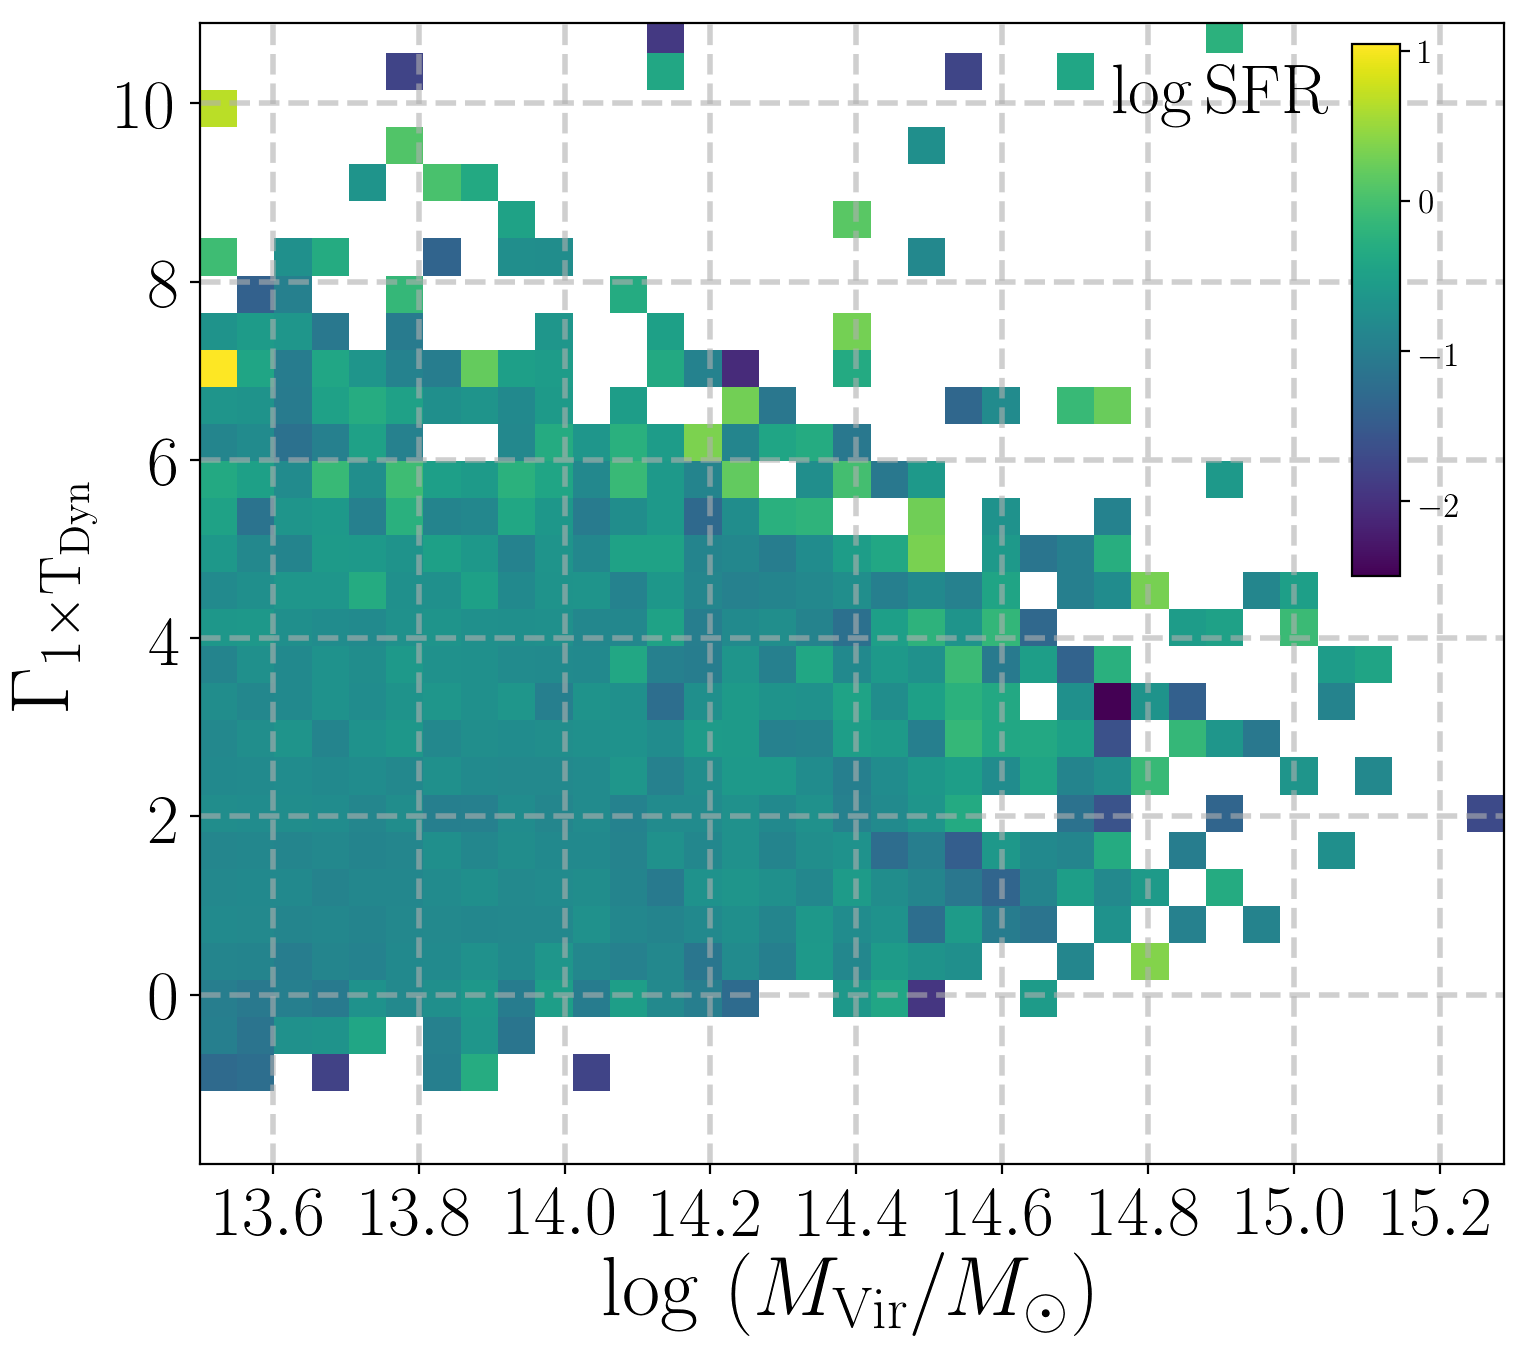

In [84]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

sfr_mean, xedges, yedges = binned_statistic_2d(
    um_cen[mask_massive]['logmh_vir'], gamma_sp[mask_massive],
    np.log10(um_cen[mask_massive]['sfr']), 
    'mean', bins=[35, 40])

cax1 = ax1.imshow(sfr_mean.T, origin='lower', vmin=-2.5,
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                  aspect='auto', interpolation='nearest')

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.60, 0.03, 0.38]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.text(0.70, 0.92, r'$\log\mathrm{SFR}$', fontsize=25, transform=ax1.transAxes)

ax1.set_ylim(-1.9, 10.9)

_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\Gamma_{1\times \mathrm{T}_{\mathrm{Dyn}}}$', fontsize=30)

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


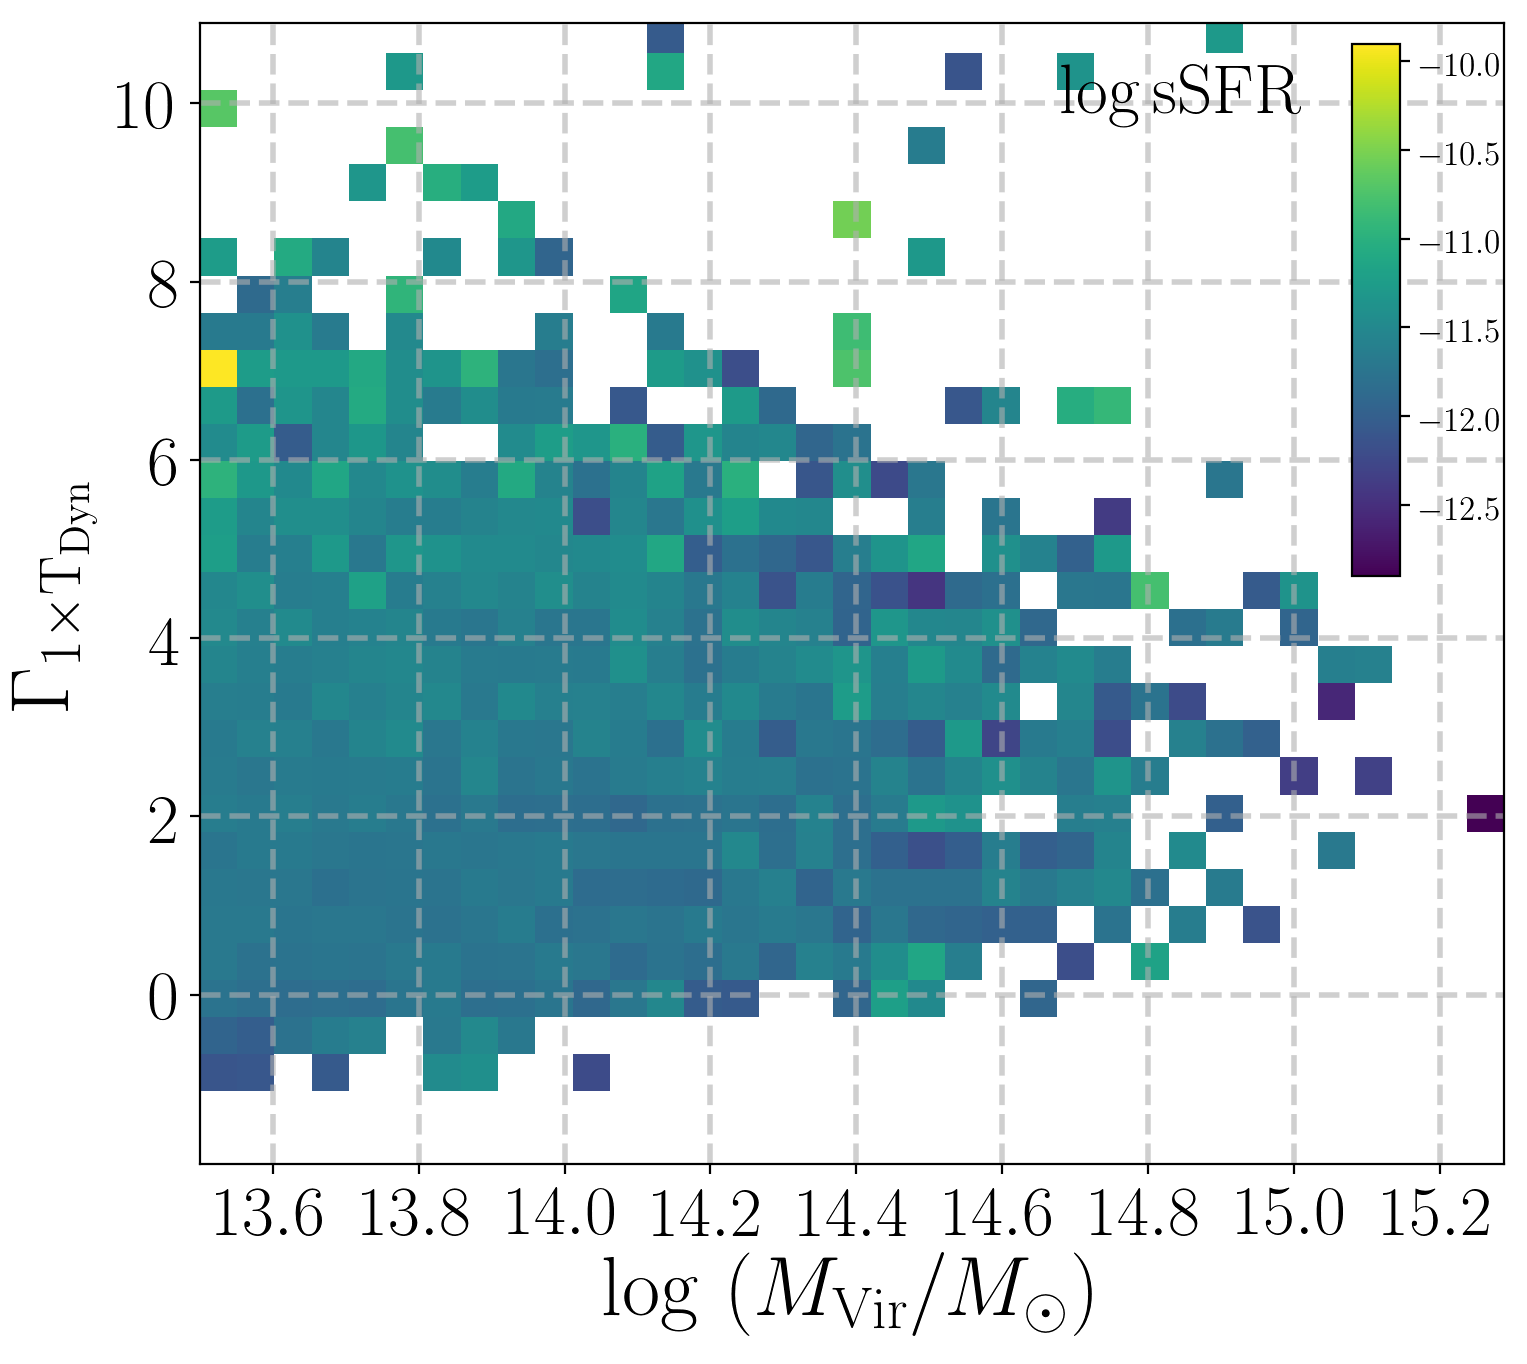

In [89]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(left=0.18, right=0.995, 
                    bottom=0.18, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

sfr_mean, xedges, yedges = binned_statistic_2d(
    um_cen[mask_massive]['logmh_vir'], gamma_sp[mask_massive],
    np.log10(um_cen[mask_massive]['ssfr']), 
    'mean', bins=[35, 40])

cax1 = ax1.imshow(sfr_mean.T, origin='lower', vmin=-12.9,
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                  aspect='auto', interpolation='nearest')

ax1.grid(linestyle='--', alpha=0.6, linewidth=2.0)

cbaxes1 = fig.add_axes([0.90, 0.60, 0.03, 0.38]) 
cbar1 = fig.colorbar(cax1, cax=cbaxes1)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_ylim(-1.9, 10.9)

ax1.text(0.66, 0.92, r'$\log\mathrm{sSFR}$', fontsize=25, transform=ax1.transAxes)
    
_ = ax1.set_xlabel(r'$\log\ (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\Gamma_{1\times \mathrm{T}_{\mathrm{Dyn}}}$', fontsize=30)